In [1]:
%matplotlib notebook
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import pandas as pd

import sklearn

from sklearn.metrics import roc_auc_score

In [2]:
# To Do
    # Ad citation 
    # Ad theory

In [3]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer, GradientDescentOptimizer

In [4]:
# Set a random seed
np.random.seed(42)

In [5]:
# Generate training and test data

num_training = 200
num_test = 2000

label=['signal','lepton 1 pT', 'lepton 1 eta', 'lepton 1 phi', 'lepton 2 pT', 'lepton 2 eta', 'lepton 2 phi', 'missing energy magnitude', 'missing energy phi', 'MET_rel', 'axial MET', 'M_R', 'M_TR_2', 'R', 'MT2', 'S_R', 'M_Delta_R', 'dPhi_r_b', 'cos(theta_r1)']
var=['lepton 1 pT','lepton 2 pT','missing energy magnitude']

df=pd.read_csv('Data/SUSY.csv',names=label,nrows=(num_training+num_test))



Xdata=df[var].to_numpy()
Ydata=df['signal'].to_numpy()

X_train=Xdata[:200]
y_train=Ydata[:200]

X_test=Xdata[200:]
y_test=Ydata[200:]


In [6]:

def plot_data_3(x,y,fig=None,ax=None):
    
    color=['r' if y[i]==1  else 'b' for i in range(len(y))]

    feature_1=[]
    for i in range(len(x)):
        feature_1.append(x[i][0])
    
    feature_2=[]
    for i in range(len(x)):
        feature_2.append(x[i][1])
    
    feature_3=[]
    for i in range(len(x)):
        feature_3.append(x[i][2])

    ax=Axes3D(fig)
    ax.scatter(feature_1,feature_2,feature_3,color=color)
    ax.set_xlabel('feature_1')
    ax.set_ylabel('feature_2')
    ax.set_zlabel('feature_3')




In [7]:
fig = plt.figure(figsize=plt.figaspect(1))
ax = fig.add_subplot(1, 2, 1, projection='3d')
plot_data_3(X_train,y_train,fig=fig,ax=ax)

<IPython.core.display.Javascript object>

In [8]:
label_0 = [[1], [0]]  #|0>
label_1 = [[0], [1]]  #|1>
state_labels = [label_0, label_1]


# Define output labels as quantum state vectors
def density_matrix(state):
    """Calculates the density matrix representation of a state.

    Args:
        state (array[complex]): array representing a quantum state vector

    Returns:
        dm: (array[complex]): array representing the density matrix
    """
    return state * np.conj(state).T

In [9]:
# device 
dev = qml.device("default.qubit", wires=1)

@qml.template
def simpleLayer_3features(p,x,wire):
    qml.Rot(*x, wires=wire)
    qml.Rot(*p, wires=wire)
    
    
@qml.qnode(dev)
def qcircuit(params, x, y):
    """
    Args:
        params (array[float]): array of parameters
        x (array[float]): single input vector
        y (array[float]): single output state density matrix

    Returns:
        float: fidelity between output state and input
    """
    qml.Hadamard(0)
    for p in params:
        simpleLayer_3features(p,x,wire=0)
        

    return qml.expval(qml.Hermitian(y, wires=[0])) 


def cost(params, x, y, state_labels=None):
    """Cost function to be minimized.

    Args:
        params (array[float]): array of parameters
        x (array[float]): 2-d array of input vectors
        y (array[float]): 1-d array of targets
        state_labels (array[float]): array of state representations for labels

    Returns:
        float: loss value to be minimized
    """
    # Compute prediction for each input in data batch
    loss = 0.0
    dm_labels = [density_matrix(s) for s in state_labels]
    ##print("dm_labels:",dm_labels)
    for i in range(len(x)):
        i=int(i)
        ##print("dm_labels[yi]:",dm_labels[int(y[i])])
        f = qcircuit(params, x[i], dm_labels[int(y[i])])
        ##print("f",f)
        loss = loss + (1 - f) ** 2
    return loss / len(x)

In [10]:
def test(params, x, y, state_labels=None):
    """
    Tests on a given set of data.

    Args:
        params (array[float]): array of parameters
        x (array[float]): 3-d array of input vectors
        y (array[float]): 1-d array of targets
        state_labels (array[float]): 1-d array of state representations for labels

    Returns:
        predicted (array([int]): predicted labels for test data
        output_states (array[float]): output quantum states from the circuit
    """
    fidelity_values = []
    dm_labels = [density_matrix(s) for s in state_labels]
    predicted = []

    for i in range(len(x)):
        fidel_function = lambda y: qcircuit(params, x[i], y)
        fidelities = [fidel_function(dm) for dm in dm_labels]
        best_fidel = np.argmax(fidelities)

        predicted.append(best_fidel)
        fidelity_values.append(fidelities)

    return np.array(predicted), np.array(fidelity_values)


def accuracy_score(y_true, y_pred):
    """Accuracy score.

    Args:
        y_true (array[float]): 1-d array of targets
        y_predicted (array[float]): 1-d array of predictions
        state_labels (array[float]): 1-d array of state representations for labels

    Returns:
        score (float): the fraction of correctly classified samples
    """
    score = y_true == y_pred
    return score.sum() / len(y_true)


def iterate_minibatches(inputs, targets, batch_size):
    """
    A generator for batches of the input data

    Args:
        inputs (array[float]): input data
        targets (array[float]): targets

    Returns:
        inputs (array[float]): one batch of input data of length `batch_size`
        targets (array[float]): one batch of targets of length `batch_size`
    """
    for start_idx in range(0, inputs.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield inputs[idxs], targets[idxs]


In [11]:
# Train using Adam optimizer and evaluate the classifier
num_layers = 3
learning_rate = 0.6
epochs = 20
batch_size = 40

opt = AdamOptimizer(learning_rate, beta1=0.9, beta2=0.999)


# initialize random weights
params = np.random.uniform(size=(num_layers, 3))


# untrain prediction
predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
accuracy_train = accuracy_score(y_train, predicted_train)

predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
accuracy_test = accuracy_score(y_test, predicted_test)

# save predictions with random weights for comparison
initial_predictions = predicted_test

loss = cost(params, X_test, y_test, state_labels)

print(
    "Epoch: {:2d} | Cost: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
        0, loss, accuracy_train, accuracy_test
    )
)

for it in range(epochs):
    for Xbatch, ybatch in iterate_minibatches(X_train, y_train, batch_size=batch_size):
        params = opt.step(lambda v: cost(v, Xbatch, ybatch, state_labels), params)

    predicted_train, fidel_train = test(params, X_train, y_train, state_labels)
    accuracy_train = accuracy_score(y_train, predicted_train)
    loss = cost(params, X_train, y_train, state_labels)

    predicted_test, fidel_test = test(params, X_test, y_test, state_labels)
    accuracy_test = accuracy_score(y_test, predicted_test)
    res = [it + 1, loss, accuracy_train, accuracy_test]
    print(
        "Epoch: {:2d} | Loss: {:3f} | Train accuracy: {:3f} | Test accuracy: {:3f}".format(
            *res
        )
    )

Epoch:  0 | Cost: 0.449797 | Train accuracy: 0.335000 | Test accuracy: 0.348500
Epoch:  1 | Loss: 0.275048 | Train accuracy: 0.620000 | Test accuracy: 0.626500
Epoch:  2 | Loss: 0.253128 | Train accuracy: 0.660000 | Test accuracy: 0.672500
Epoch:  3 | Loss: 0.228248 | Train accuracy: 0.680000 | Test accuracy: 0.690000
Epoch:  4 | Loss: 0.202455 | Train accuracy: 0.700000 | Test accuracy: 0.680000
Epoch:  5 | Loss: 0.188464 | Train accuracy: 0.725000 | Test accuracy: 0.702500
Epoch:  6 | Loss: 0.187265 | Train accuracy: 0.715000 | Test accuracy: 0.698000
Epoch:  7 | Loss: 0.186177 | Train accuracy: 0.760000 | Test accuracy: 0.701000
Epoch:  8 | Loss: 0.182970 | Train accuracy: 0.750000 | Test accuracy: 0.702000
Epoch:  9 | Loss: 0.181366 | Train accuracy: 0.760000 | Test accuracy: 0.710000
Epoch: 10 | Loss: 0.180956 | Train accuracy: 0.730000 | Test accuracy: 0.708000
Epoch: 11 | Loss: 0.180794 | Train accuracy: 0.760000 | Test accuracy: 0.718000
Epoch: 12 | Loss: 0.180170 | Train accur

In [12]:
fig = plt.figure(figsize=plt.figaspect(1))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')

plot_data_3(X_test, initial_predictions, fig, ax1)

plt.show()

<IPython.core.display.Javascript object>

In [13]:
fig = plt.figure(figsize=plt.figaspect(1))
ax2 = fig.add_subplot(1, 2, 1, projection='3d')

plot_data_3(X_test, predicted_test, fig, ax2)

plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


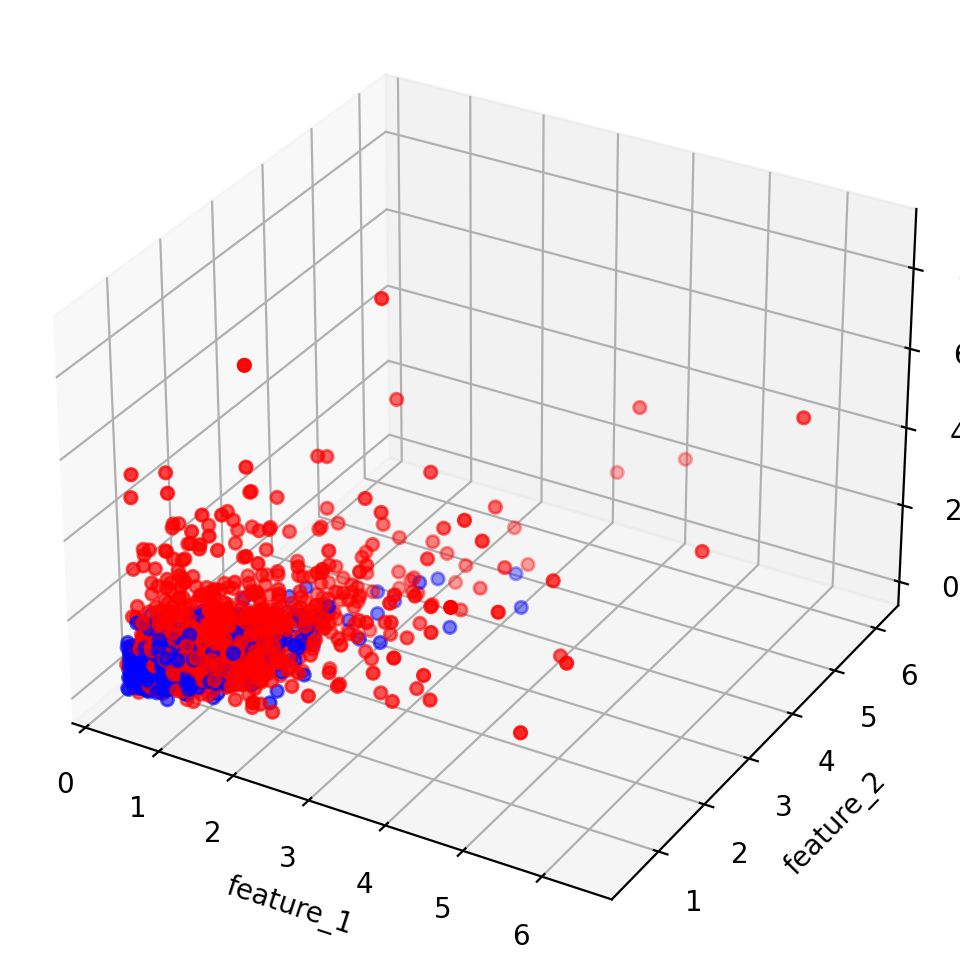

In [15]:
fig = plt.figure(figsize=plt.figaspect(1))
ax3 = fig.add_subplot(1, 2, 1, projection='3d')

plot_data_3(X_test, y_test, fig, ax3)


plt.show()

In [17]:
AUC=roc_auc_score(predicted_test,y_test)
print(AUC)

NameError: name 'roc_auc_score' is not defined